### ETAS: Papa New Guinea G2016
#### 2016-12-06 22:03:32 (UTC) m=6.5

#### and 2017-01-22 04:30:23 (UTC)

Time
2017-01-22 04:30:23 (UTC)
Location
6.214°S 155.122°E
Depth
136.0 km

In [20]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
import global_etas_auto as ggep
from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

#from geopy.geocoders import Nominatim


#
# on a fresh linux install... (can we script this?)
# stuff we have to do besides just clone this:
# pip install geopy
# conda install basemap
# pip install geographiclib
# conda install -c ioos rtree


In [22]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#
#gl = Nominatim()
#
# Time
# 2016-12-17 10:51:12 (UTC)
# Location
# 4.509°S 153.450°E
# Depth
# 103.2 km
#
event_name = 'Papa_New_Guinea_2016'
# apparently not getting corect geocoding...
#png = gl.geocode('Papa New Guinea')
#lon0 = png.longitude
#lat0 = png.latitude
lon0 = 153.45
lat0 = -4.509
#
Lr_factor = 10.
#
#t0 = dtm.datetime(2016, 12, 6, 22, 3, 32, tzinfo=pytz.timezone('UTC'))
t0 = dtm.datetime(2017, 1, 22, 4,30,23, tzinfo=pytz.timezone('UTC'))
t_ms = t0
to_dt = dtm.datetime.now(pytz.utc)
#
m0 = 7.8
d_lat=5.
d_lon=5.
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]

#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#

In [23]:
#anss_cat = atp.catfromANSS(lat=[28.6-2., 38.6+2.], lon=[-122., -118.], minMag=1.0)
#print("len(cat): ", len(anss_cat))

In [24]:
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)

eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 
               'd_lat': .1, 'd_lon':.1, 'mc': 2.5,'etas_range_factor':30.0, 'etas_range_padding':1.5,  
               'lats': lats, 'p': 1.1, 'b1': 1.0, 'q': 1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 1.0, 'd_lambda': 1.76, 
               'ab_ratio_expon':.25 }
eq_prams.update({'d_lat': .1, 'd_lon':.1, 'mc': 1.5,'etas_range_factor':30.0, 'etas_range_padding':1.5 })

print('active prams: ', eq_prams)
# prototype of GlobalNet NZ catalog:
#nz_cat0 = test_cat = atp.cat_from_geonet(lats=lats, lons=lons, m_c=2.5, date_from=dtm.datetime(2000,1,1,tzinfo=atp.tzutc),
#                              date_to=dtm.datetime.now(atp.tzutc))
#nz_cat = gep.make_ETAS_catalog_mpp(incat=nz_cat0)


active prams:  {'mc': 1.5, 'ab_ratio_expon': 0.25, 'b1': 1.0, 'dmstar': 1.0, 'lats': [-9.509, 0.49099999999999966], 'do_recarray': True, 'd_lat': 0.1, 'd_tau': 2.28, 'lons': [148.45, 158.45], 'D_fract': 1.5, 't_0': datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), 'd_lon': 0.1, 't_now': datetime.datetime(2017, 1, 23, 6, 28, 21, 193823, tzinfo=<UTC>), 'fit_factor': 1.0, 'etas_range_factor': 30.0, 'b2': 1.5, 'd_lambda': 1.76, 'incat': None, 'etas_range_padding': 1.5, 'q': 1.5, 'p': 1.1}


#### Make a composite catalog
- Combine the ANSS catalog with the USGS  one-week, most recent events catalog.
- (this could use some testing and refinement probably).

In [25]:
cat_usgs_0 = atp.cat_from_usgs(duration='week', mc=2.5, rec_array=True)
cat_usgs = [rw for rw in cat_usgs_0 if rw['lon']>lons[0] and rw['lon']<lons[1] and rw['lat']>lats[0] and rw['lat']<lats[1]
            and rw['mag']>eq_prams['mc']]
cat_usgs = numpy.core.records.fromarrays(zip(*cat_usgs), dtype=cat_usgs_0.dtype)
cat_anss = atp.catfromANSS(lon=eq_prams['lons'], lat=eq_prams['lats'], 
                           dates0=[to_dt-dtm.timedelta(days=365*5), dtm.datetime.now(pytz.utc)-dtm.timedelta(days=7)],
                           minMag=eq_prams['mc'])
#
new_cat = numpy.append(cat_usgs, cat_anss)
new_cat.sort(order='event_date')
#new_cat.sort(key=lambda rw: rw[0])
#new_cat = numpy.rec.array(new_cat, dtype=cat_anss.dtype)

print('descr: ', new_cat.dtype.descr)
#print('cescr2: ', cat_anss.dtype.descr)
#
etas_catalog = globalETAS.make_ETAS_catalog(incat=new_cat, lats=eq_prams['lats'], lons=eq_prams['lons'],
                                            mc=eq_prams['mc'], date_range=[to_dt-dtm.timedelta(days=365*5),
                                                                           dtm.datetime.now(pytz.utc)])

url_str: http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_week.csv
data handle fetched...
 no file.
descr:  [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8')]


In [26]:
#etas = gep.ETAS_mpp(n_cpu=2*mpp.cpu_count(), catalog=nz_cat, **eq_prams)
#etas = gep.ETAS_mpp(n_cpu=2*mpp.cpu_count(), catalog=None, **eq_prams)
etas = gep.ETAS_mpp(n_cpu=2*mpp.cpu_count(), catalog=etas_catalog, **eq_prams)
#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-01-25 06:28:21.193823+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3056], None)
make_etas():
etas_mpp worker xyz_range:  [0, 2500]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-01-25 06:28:21.193823+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3056], [0, 2500])
etas_mpp worker xyz_range:  [2500, 5000]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-01-25 06:28:21.193823+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 3056], [2500, 5000])
etas_mpp worker xyz_range:  [5000, 7500]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t

In [27]:
#
f_path = '/home/myoder/Dropbox/Research/etas/{}/etas_{}'.format(event_name, etas.t_now)
f_root = 'etas_{}'.format(event_name)

#print(etas.t0, etas.t_now, etas.t_forecast, etas.catalog[-1])
print(to_dt)
print(etas.t_0, mpd.num2date(etas.t_forecast), etas.t_now, t_ms)
#print(etas.catalog[-5:])

2017-01-23 06:28:21.193823+00:00
2012-01-25 06:28:21.193823+00:00 2017-01-23 06:28:21.193820+00:00 2017-01-23 06:28:21.193823+00:00 2017-01-22 04:30:23+00:00


ms:  (datetime.datetime(2017, 1, 22, 4, 30, 23, 140), -6.2137, 155.1224, 7.9, 136.0, 736351.1877662053, 154.88166189124829, 34259.057381088154, 4.3017215086876675e-08, 46.77351412871986, 6595.8761744650365, 1.6522385488895567e-05, 1.0, 1.1, 1.5, array([ 4.43489092,  0.8638143 ]), array([[ 0.93198706,  0.36249153],
       [-0.36249153,  0.93198706]]), 1500.0) 155.1224 -6.2137


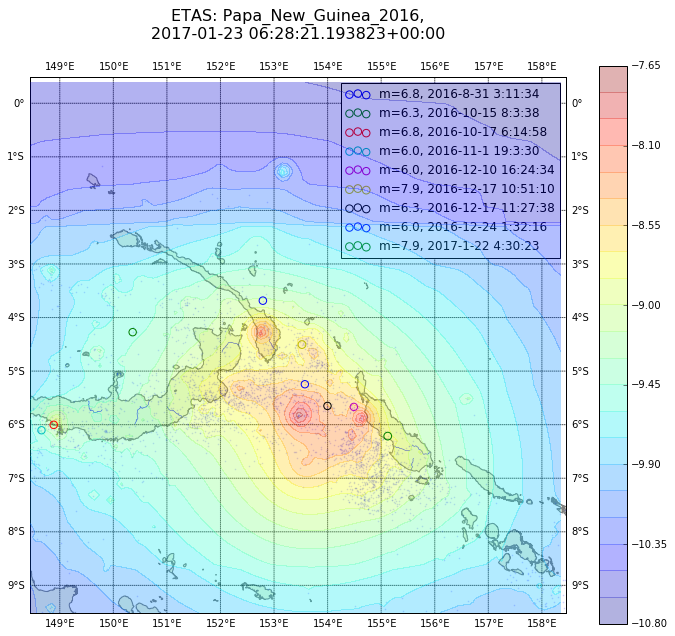

In [28]:
## TODO: do we need this? we run this figure again below...
# ... not really, but we do a bunch of variable definitions here, so...
#
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6.0
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>t_ms-dtm.timedelta(days=180)]

# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, *{}*'.format(m0, dt_str))
#
ax.set_title('ETAS: {},\n{}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))
    #
#
etas.cm.scatter(etas.catalog['lon'], etas.catalog['lat'], s=2., edgecolors='b', c='b', marker='.', zorder=6, alpha=.15)
plt.gca().legend(loc='upper right')

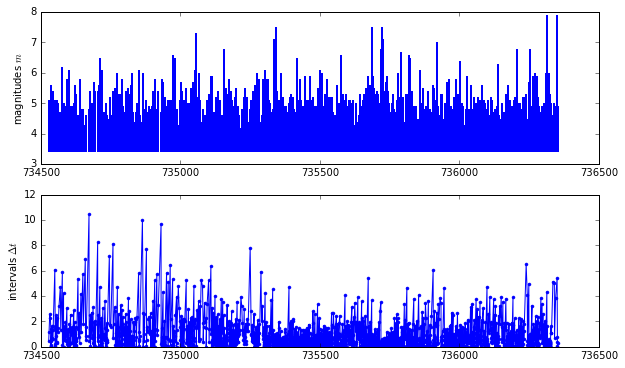

In [29]:
plt.figure(figsize=(10,6))
plt.clf()
ax1 = plt.subplot('211')
ax2 = plt.subplot('212', sharex=ax1)
#ax1.plot(etas.catalog['event_date'], etas.catalog['mag'], marker='.', ls='-', label='mag')
f_dates = [mpd.date2num(x.astype(dtm.datetime)) for x in etas.catalog['event_date']]
ax1.vlines(f_dates, (min(etas.catalog['mag'])-.5)*numpy.ones(len(etas.catalog)), 
           etas.catalog['mag'], lw=2., label='mag', color='b')
ax2.plot(f_dates[1:], numpy.diff(f_dates,1), '.-')

ax2.set_ylabel('intervals $\Delta t$')
ax1.set_ylabel('magnitudes $m$')

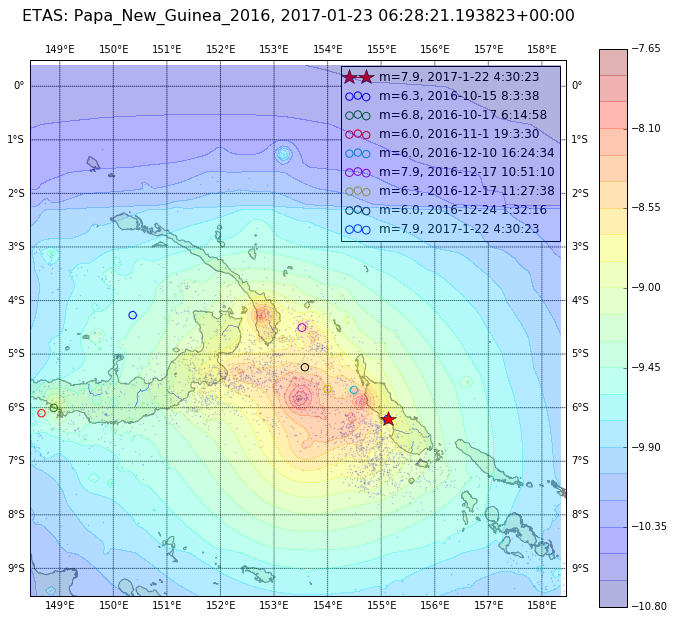

In [30]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)

#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6.0
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=120)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
                   label='m={}, {}'.format(mainshock['mag'], dt_str))
ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=3*(m6['mag']+12.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))
    #

#
etas.cm.scatter(etas.catalog['lon'], etas.catalog['lat'], s=2., edgecolors='b', c='b', marker='.', zorder=6, alpha=.2)
plt.gca().legend(loc='upper right')

In [31]:
for rw in m6s:
    print(rw)

(datetime.datetime(2016, 10, 15, 8, 3, 38, 150000), -4.2735, 150.3606, 6.3, 442.0, 736252.3358582176, 24.547089156850298, 661.4388427934773, 1.2324949488989722e-05, 7.413102413009177, 89.66146431202439, 0.0010109726745738984, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 4.0)
(datetime.datetime(2016, 10, 17, 6, 14, 58, 270000), -6.0033, 148.8871, 6.8, 42.0, 736254.2603966435, 43.65158322401658, 2270.9312198321218, 2.103429716768092e-06, 13.182567385564074, 343.5098229842779, 0.00027951562104536713, 1.0, 1.1, 1.5, array([ 4.43489092,  0.8638143 ]), array([[ 0.93198706,  0.36249153],
       [-0.36249153,  0.93198706]]), 100.0)
(datetime.datetime(2016, 11, 1, 19, 3, 30, 100000), -6.1039, 148.6588, 6.0, 51.99, 736269.7940983797, 17.378008287493753, 315.54486979880295, 3.5604052586519205e-05, 5.248074602497728, 40.05030495641046, 0.002186449330282818, 1.0, 1.1, 1.5, array([ 4.43489092,  0.8638143 ]), array([[ 0.93198706,  0.36249153],
       [-0.36249153,  0.9319

In [32]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))), 
                kml_contours_bottom=.25, kml_contours_top=1.0)
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))

with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
    pickle.dump(etas, fpkl)


kml bottom, top:  5 21


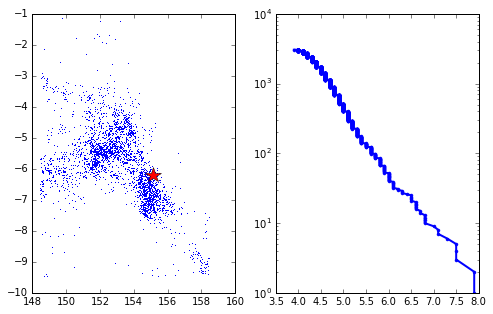

In [33]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [34]:
#print(etas.mc, etas.mc_etas)

In [35]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

In [ ]:
mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)


data handle fetched...
 no file.


In [ ]:
test_cat = atp.catfromANSS(lat=lats, lon=lons, minMag=1.5,
                           dates0=[dtm.datetime(1990,1,1, tzinfo=pytz.utc), dtm.datetime.now(pytz.utc)])


plt.figure()
plt.clf()
#plt.plot(test_cat['lon'], test_cat['lat'], '.')
print(test_cat[-5:])
print(max(test_cat['event_date']))

plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(test_cat['lon'], test_cat['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(test_cat['mag']))], numpy.arange(1,len(test_cat)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

data handle fetched...
